#Terms of Use
By using this colab to download the brain dataset (i.e., data including fMRI, images, labels), you agree to the following terms:

1. You will use the Datasets only for non-commercial research and educational purposes.
2. You will NOT distribute the Datasets or any parts thereof.
3. Massachusetts Institute of Technology make no representations or warranties regarding the datasets, including but not limited to warranties of non-infringement or fitness for a particular purpose.
4. You accept full responsibility for your use of the datasets and shall defend and indemnify Massachusetts Institute of Technology and International Business Machines Corporation, including its employees, officers and agents, against any and all claims arising from your use of the datasets, including but not limited to your use of any copyrighted images that you may create from the datasets.
5. You will treat people appearing in this data with respect and dignity.
6. This data comes with no warranty or guarantee of any kind, and you accept full liability.

# Summary
**Goal:** Here we show how to prepare submission for Algonauts 2021 challenge using Resnet18/Resnet18_3D as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Estimate the voxel reliability using training data.
2. Feedforward the videos from stimulus set to the Resnet18/Resnet18_3D model pretrained on Imagenet dataset to extract Resnet18/Resnet18_3D activations from different layers and apply PCA for dimensionality reduction.
3.   Train a linear regression to predict fMRI responses from Resnet18/Resnet18_3D activations.
4.   Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set and compare two model performances
5. Generate predicted fMRI responses to test videos for all subjects all ROIs
6. Preparing submission files for codalab



# Setup

In [ ]:
#@title Installations
%%capture
!pip install torchextractor
!pip install nilearn
!pip install decord

In [ ]:
#@title Imports
%%capture
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
import torchvision
import torchextractor as tx
import itertools
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9). 

In [ ]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link 
!wget -O participants_data.zip -c $download_link  
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
--2021-11-03 11:06:25--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/agxyxntrbwko7t1/participants_data.zip [following]
--2021-11-03 11:06:25--  https://www.dropbox.com/s/raw/agxyxntrbwko7t1/participants_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fa483227e3c5a043cf4b11609.dl.dropboxusercontent.com/cd/0/inline/BZRoKdlDBuwK1GnweGD8Lgd1ojtYL-ES_KuVUbTZ0jtidjxD-blz_XbvxfAwkvqpo68O8AKswCWFV3k53El3hNwPlZs9tDy1GHN-gCukUwmc8z5xqrt5ugQXVsdnIECwKL1VL0LqmCWWz86ack-icem2/file# [following]
--2021-11-03 11:06:26--  https://uc3fa483227e3c5a043cf4b11609.dl.dropboxusercontent.com/c

#fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge. 

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.
 

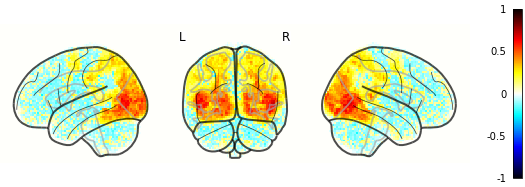

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


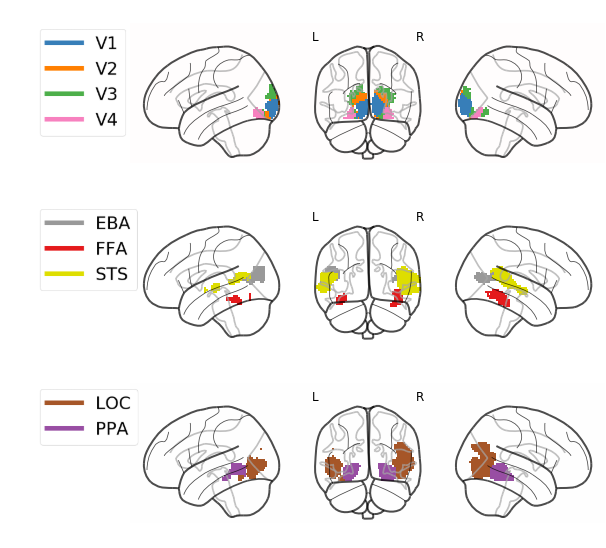

#Loading fMRI data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [ ]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
    fmri_dir = './participants_data_v2021' 
    track = "full_track"
    results_dir = '/content/'
    track_dir = os.path.join(fmri_dir, track) 
    sub_fmri_dir = os.path.join(track_dir, sub)
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
    brain_mask = '/content/example.nii'
    nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
    saveasnii(brain_mask,nii_save_path,visual_mask_3D)
    plotting.plot_glass_brain(nii_save_path,
                            title='fMRI response',plot_abs=False,
                            display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def get_fmri_all_trials(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data["train"], voxel_mask

    return ROI_data["train"]

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [ ]:
#@title Visualize video
vid_id = 100 #@param {type: "integer"}
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_list[vid_id],'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

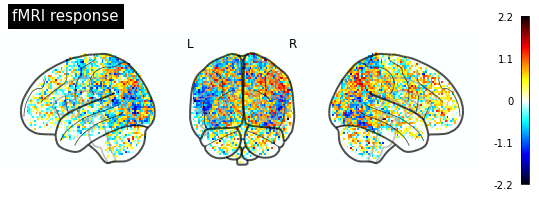

In [ ]:
#@title Visualize corresponding brain response
sub = 'sub01'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
visualize_activity(vid_id,sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

In [ ]:
#@title Loading ROI responses
# path to ROI file
ROI_file = "/content/participants_data_v2021/full_track/sub04/WB.pkl"

# loading .pkl file
ROI_data = load_dict(ROI_file)
print(ROI_data.keys())

# print the data dimensions
print(ROI_data['train'].shape)
print(ROI_data['voxel_mask'].shape)

dict_keys(['train', 'voxel_mask'])
(1000, 3, 19445)
(78, 93, 71)


Here the training data is a 3-dimensional matrix containing fMRI responses to 1000 training videos from 19445 voxels. Each video was shown to participant 3 times, the 2nd dimension refers to 3 repetitions.

The voxel mask is a 3D cube representing width, height and depth of the fMRI cube and has the value 1 for reliable voxels and 0 for others. It is used to project the results back to brain for visualization purposes. 

# Estimating Reliability using training data

In [ ]:
#@title Functions to estimate reliability of voxels
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    covariance = covariance / (x.shape[dim])

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = covariance / (x_std * y_std)

    return corr.ravel()


def get_splithalf_reliability(fmri_all_trials):
    # number of repetitions 
    num_reps =  fmri_all_trials.shape[1]
    possible_inds = range(num_reps)

    # split size defined by L
    L = int(num_reps/2)
    splits_a = []

    # This for loop generates all possible ways of selecting
    # num_reps/2 indices from num_reps (=3 here)
    for subset in itertools.combinations(possible_inds, L):
        splits_a.append(np.array(subset))
    
    # Number of unique splits 
    splits_a = splits_a[:len(splits_a)//2+1]

    # initialing rho which will store split-half correlation for all voxels 
    rho = np.zeros(fmri_all_trials.shape[2])

    ## Calculating the correlation between two splits and 
    ## then averaging to get noise_ceiling
    for split_a in tqdm(splits_a):
        split_b = np.delete(possible_inds, split_a)
        a = fmri_all_trials[:,split_a,:]
        b = fmri_all_trials[:,split_b,:]
        a = np.mean(a,axis=1)
        b = np.mean(b,axis=1)
        temp_corr = vectorized_correlation(a, b)
        rho += temp_corr
    rho = rho/len(splits_a)

    # Spearman - brown reliability definition from Wikipedia https://en.wikipedia.org/wiki/Spearman%E2%80%93Brown_prediction_formula
    reliability = 2*rho/(1+rho)
    return reliability

def visualize_reliability(reliability,voxel_mask):
    visual_mask_3D = np.zeros((78,93,71))
    visual_mask_3D[voxel_mask==1]= reliability
    brain_mask = '/content/example.nii'
    nii_save_path =  os.path.join('/content/reliability.nii')
    saveasnii(brain_mask,nii_save_path,visual_mask_3D)
    plotting.plot_glass_brain(nii_save_path,
                            title='Voxel reliability (Training)',plot_abs=False,
                            display_mode='lyr',colorbar=True)

100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


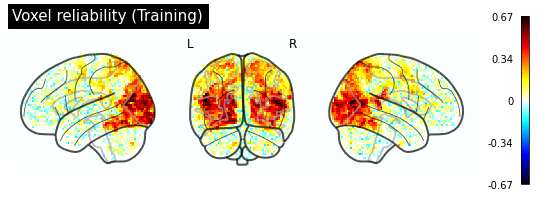

In [ ]:
sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROI = "WB"

####### setting up paths to fMRI directory for given subject and ROI ######
fmri_dir = '/content/participants_data_v2021'
if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
track_dir = os.path.join(fmri_dir, track)
sub_fmri_dir = os.path.join(track_dir, sub)
####### setting up paths to fMRI directory for given subject and ROI ######

# Wrapper to load fMRI data
fmri_train_alltrials,voxel_mask = get_fmri_all_trials(sub_fmri_dir, ROI)

# Calculate split-half reliability using training data
reliability = get_splithalf_reliability(fmri_train_alltrials)

# Reliability visualization
visualize_reliability(reliability,voxel_mask)

#Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses. 

In [ ]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save_image_model(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = {}
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            model_output, img_feature = model(input_img)
            for layer_name, f in img_feature.items():
                if frame==0:
                    activations[layer_name] = f.data.cpu().numpy().ravel()
                else:
                    activations[layer_name] += f.data.cpu().numpy().ravel()
        for layer_name, f in img_feature.items():
            save_path = os.path.join(activations_dir, video_file_name+"_"+layer_name + ".npy")
            avg_layer_activation = activations[layer_name]/float(num_frames)
            np.save(save_path,avg_layer_activation)

def get_activations_and_save_video_model(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((112,112)),
            trn.ToTensor(),
            trn.Normalize([0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989])])

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = {}
        input_vid = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            input_vid.append(input_img)
        input_vid = torch.cat(input_vid)
        input_vid = input_vid.permute(1,0,2,3).unsqueeze(0)
        model_output, vid_feature = model(input_vid)

        for layer_name, f in vid_feature.items():
            save_path = os.path.join(activations_dir, video_file_name+"_"+layer_name + ".npy")
            np.save(save_path,vid_feature[layer_name].data.cpu().numpy().ravel())


def do_PCA_and_save(activations_dir, save_dir,layers):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    layers: list
        list of strings with layer names to perform pca
    """
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)

In [ ]:
#@title Model definitions

# Get all the video file paths in a list
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))

# Model defintions : Resnet18 image model and Resnet18 3D video model
models = { "resnet18_random": torchvision.models.resnet18(pretrained=False),
           "r3d_18_random":  torchvision.models.video.r3d_18(pretrained=False),
          "resnet18": torchvision.models.resnet18(pretrained=True),
           "r3d_18":  torchvision.models.video.r3d_18(pretrained=True),}

# print list of layers in current model
print(tx.list_module_names(models["resnet18"]))
print(tx.list_module_names(models["r3d_18"]))

Total Number of Videos:  1102


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


  0%|          | 0.00/127M [00:00<?, ?B/s]

['', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3', 'layer3.0', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4', 'layer4.0', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'layer4.1', 'layer4.1.

In [ ]:
#@title Feature extraction

# Extract features for all the models selected in the previous cell
for model_name,model in models.items():

    # which layers to select
    layers = ["layer4", "avgpool"]
    # feature extractor
    model = tx.Extractor(model, layers)
    if torch.cuda.is_available():
      model = model.cuda()
    
    # extract and save activations
    print("-------------Saving activations ------------------------")
    activations_dir = "/content/activations_" + model_name  # save directory
    if not os.path.exists(activations_dir):
        os.makedirs(activations_dir)
        
    print("Model :", model_name)
    if "3d" in model_name:
        get_activations_and_save_video_model(model, video_list, activations_dir)
    else:
        get_activations_and_save_image_model(model, video_list, activations_dir)

    # preprocessing using PCA and save
    pca_dir = os.path.join(activations_dir, 'pca_100')
    print("-------------performing  PCA----------------------------")
    do_PCA_and_save(activations_dir, pca_dir,layers)

-------------Saving activations ------------------------
Model : resnet18_random


  0%|          | 0/1102 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1102/1102 [05:50<00:00,  3.15it/s]


-------------performing  PCA----------------------------


100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


-------------Saving activations ------------------------
Model : r3d_18_random


100%|██████████| 1102/1102 [03:37<00:00,  5.06it/s]


-------------performing  PCA----------------------------


100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


-------------Saving activations ------------------------
Model : resnet18


100%|██████████| 1102/1102 [05:47<00:00,  3.17it/s]


-------------performing  PCA----------------------------


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


-------------Saving activations ------------------------
Model : r3d_18


100%|██████████| 1102/1102 [03:37<00:00,  5.08it/s]


-------------performing  PCA----------------------------


100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 



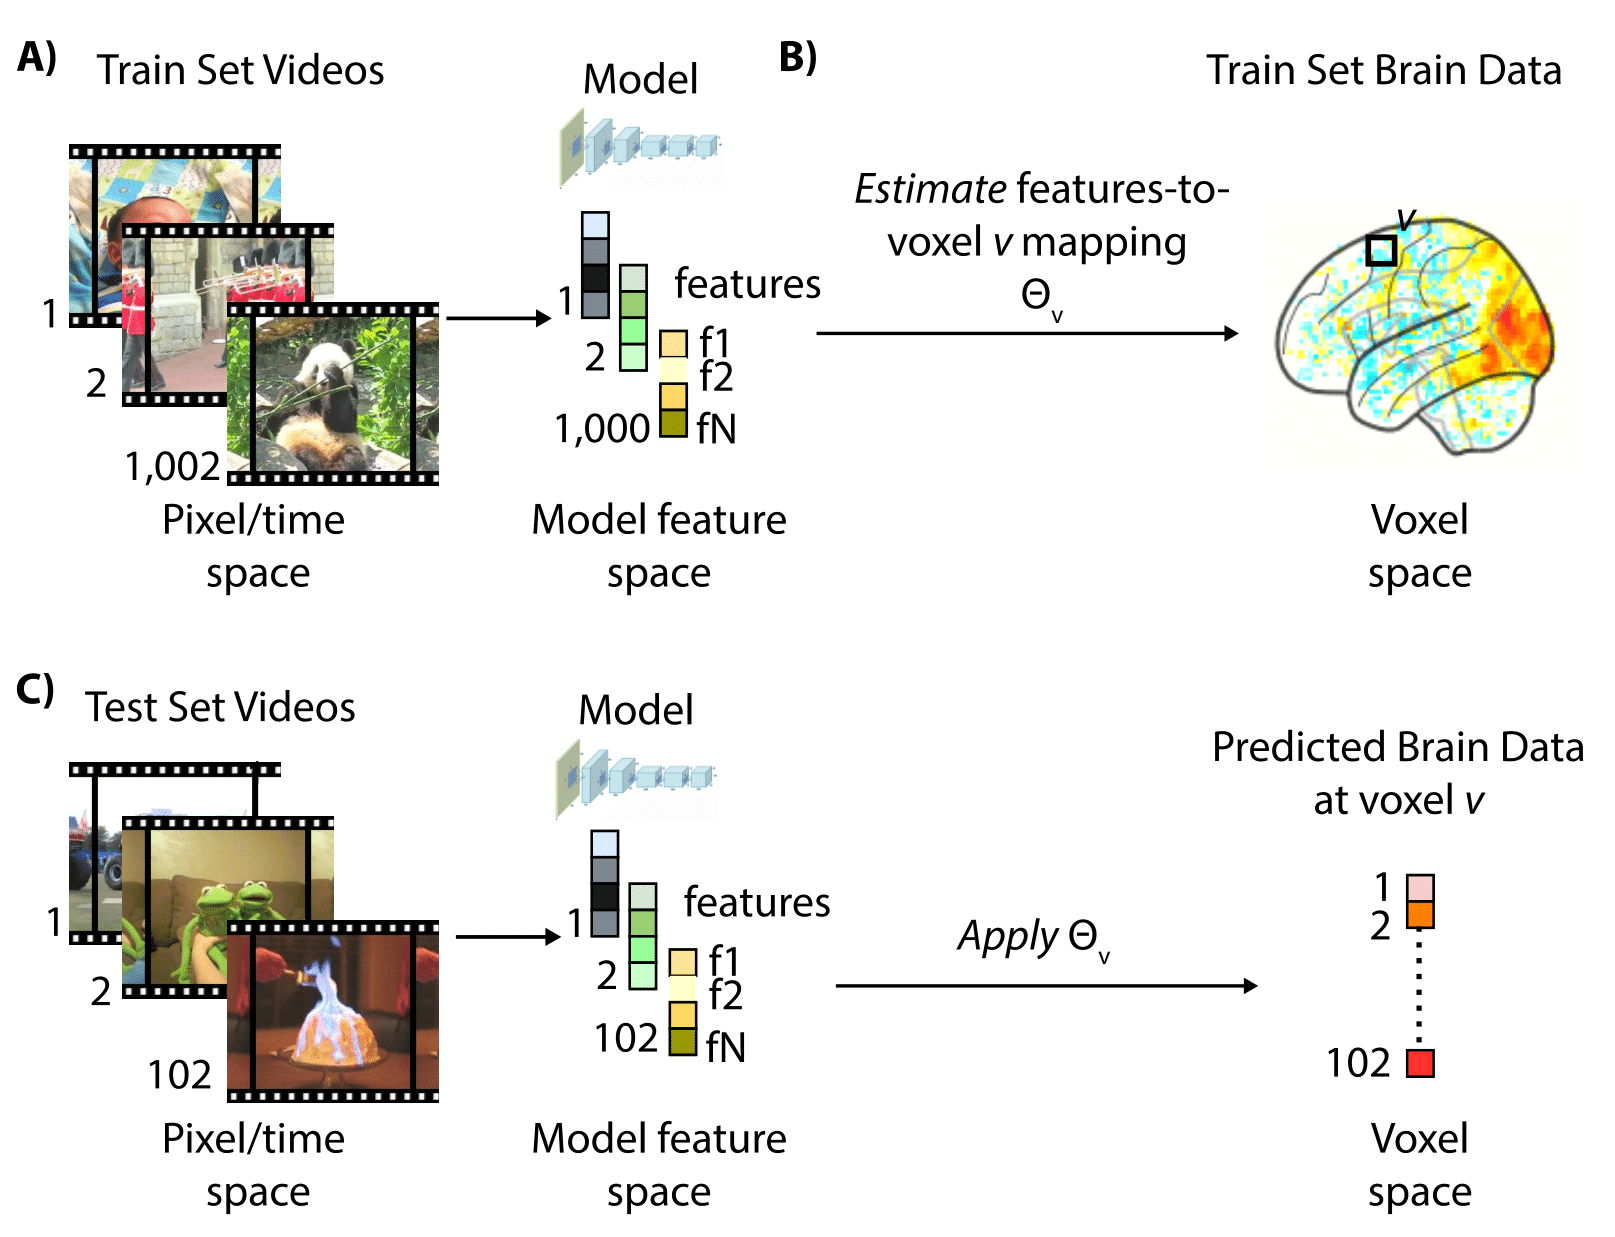

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

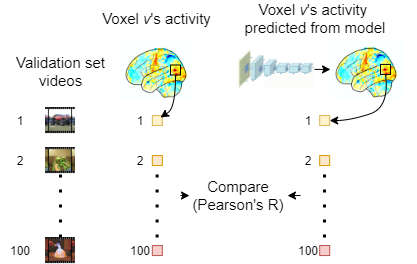

In [ ]:
#@title Utility functions for regression
class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        whether to use gpu or not.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test

            

In [ ]:
#@title Encoding wrapper
def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 102
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################
    return score.mean()

  np.save(pred_fmri_save_path, pred_fmri)
  


In [ ]:
# list of all subjects
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

#root fmri directory
fmri_dir = '/content/participants_data_v2021'

# path where to save predictions 
prediction_dir = '/content/prediction'

# list of ROIs
ROIs = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

# Initializing dictionary to store results
results_to_plot = {}

# Which layer of model for prediction
layer = 'layer4'

# for all models defined in the previous cells
for model_name,model in models.items():

    results_to_plot[model_name] = {}
    # path to activations directory
    activations_dir = "/content/activations_" + model_name

    # for loop running over all ROIs
    for ROI in ROIs:
        results_to_plot[model_name][ROI] = 0
        # loop over subjects
        for sub in subs:
            # creating results directory to save results
            results_dir = os.path.join(prediction_dir,model_name, layer,\
                                track, sub)
            if not os.path.exists(results_dir):
                os.makedirs(results_dir)

            # encoding 
            results_to_plot[model_name][ROI] += perform_encoding(activations_dir, fmri_dir,\
                                      results_dir, sub, layer, ROI=ROI)
        # averaging the correlation across subjects
        results_to_plot[model_name][ROI]/=len(subs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)


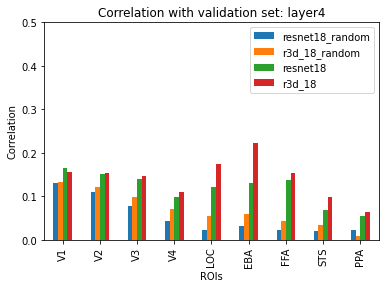

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(results_to_plot).plot(kind='bar')

plt.title("Correlation with validation set: " + layer)
plt.ylabel("Correlation")
plt.xlabel("ROIs")
plt.ylim([0,0.5])
plt.show()

# Predict fMRI responses to test videos for all subjects all ROIs
Run the cell below to save predicted fMRI responses to test videos for all subjects and ROIs.

In [ ]:
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
layer = 'layer4'
model = 'r3d_18'
for sub in subs:
  for ROI in ROIs:
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"
    results_dir = os.path.join(prediction_dir,model, layer,\
                           track, sub)
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)
    print ("Starting ROI: ", ROI, "sub: ",sub)
    perform_encoding(activations_dir, fmri_dir,\
                     results_dir, sub, layer,\
                     ROI=ROI,mode='test')
    print ("Completed ROI: ", ROI, "sub: ",sub)
    print("----------------------------------------------------------------------------")

Starting ROI:  WB sub:  sub01
Completed ROI:  WB sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub01
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
Completed ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub01
Completed ROI:  LOC sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub01
Completed ROI:  EBA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub01

#Prepare submission files

Now, we will prepare the zipfiles for submission to codalab. After running the two cells below you will see a Pickle and a zip file (containing the Pickle file) for the corresponding track in the colab file directory. 

Submit the mini_track results [here](https://competitions.codalab.org/competitions/30930#participate-submit_results) and full_track results [here](https://competitions.codalab.org/competitions/30937#participate-submit_results)

In [ ]:
def prepare_results(submission_dir, track):
    if track == 'full_track':
        ROIs = ['WB']
    else:
        ROIs = ['LOC','FFA','STS','EBA','PPA','V1','V2','V3','V4']

    num_subs = 10
    subs=[]
    for s in range(num_subs):
        subs.append('sub'+str(s+1).zfill(2))

    results = {}
    for ROI in ROIs:
        ROI_results = {}
        for sub in subs:
            ROI_result_file = os.path.join(submission_dir,track,sub,ROI+"_test.npy")
            if not os.path.exists(ROI_result_file):
                print("---------Warning : submission not ready ----------")
                print("Result not found for ",sub, " and ROI: ",ROI)
                print("Result file path: ", ROI_result_file)
                print("Please check if the directory is correct or generate predicted data for ROI: ",ROI , " in subject: ", sub)
                return
            ROI_result = np.load(ROI_result_file)
            ROI_results[sub] = ROI_result
        results[ROI] = ROI_results

    save_dict(results,track+".pkl")
    zipped_results = zipfile.ZipFile(track+".zip", 'w')
    zipped_results.write(track+".pkl")
    zipped_results.close()

In [ ]:
import zipfile
submission_dir = '/content/prediction/r3d_18/layer4'
prepare_results(submission_dir, 'full_track')
prepare_results(submission_dir, 'mini_track')

Click the folder button on the left panel and you should see zipfiles ready for submission

#Reference

[The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. 
*Cichy et al. arxiv 2021*](https://arxiv.org/abs/2104.13714v1)


